# Data

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class DogsVSCats:
    IMG_SIZE = 50
    CATS = "D:\\assets\\data\\catsVdogs\\PetImages\\Cat"
    DOGS = "D:\\assets\\data\\catsVdogs\\PetImages\\Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    cat_count = 0
    dog_count = 0

    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                # f is filename of images
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    # convert images to grayscale because colour is not an important feature for determining dogs or cats
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    # resize image to 50*50
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    # convert image to numpy array and turn dog/cat to one hot format
                    # np.eye(n) gives identity matrix of n order
                    # so np.eye(2)[0] = [1, 0] and np.eye(2)[1] = [0, 1]
                    if label == self.CATS:
                        self.cat_count += 1
                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as e:
                    # print(str(e))
                    pass
        np.random.shuffle(self.training_data)
        # shuffles data
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.cat_count)
        print("Dogs: ", self.dog_count)

In [3]:
REBUILD_DATA = False
# Change this if you want to download the data

if REBUILD_DATA:
    # we do this because after running once we save training_data using np.save() so we never have to run this again
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

[array([[ 93,  99, 118, ..., 252, 251, 253],
       [ 89,  97,  93, ..., 254, 253, 254],
       [102, 115, 104, ...,  32,  26,  24],
       ...,
       [ 79,  86,  71, ..., 211,  56,  21],
       [ 86,  76,  68, ..., 204,  76,  95],
       [ 81,  79,  70, ..., 198, 158, 158]], dtype=uint8)
 array([1., 0.])]


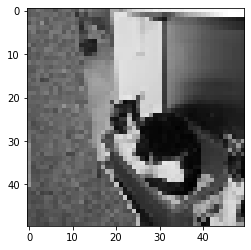

In [4]:
# Visualize
training_data = np.load("training_data.npy", allow_pickle=True)

print(training_data[0])
plt.imshow(training_data[0][0], cmap="gray")
plt.show()
# cv2.imshow("result", training_data[0][0])
# cv2.waitKey(0)

# Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

training_data = np.load("training_data.npy", allow_pickle=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # we write the model considering just one input at a time, batches get taken care of automatically
        # also the model always returns a list containing all outputs even if a single input is provided
        self.conv1 = nn.Conv2d(1, 32, 5)
        # input is 1, output is 32 convolutional feature detectors
        # basically this takes in 1 image and returns 32 convolutional images
        # we use 1 instead of 50*50 because in the end each images will be reshaped to (1, 50, 50) this is where the 1 comes from
        # 5 is kernel size(5*5 window rolls over our data to find features)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        # going from conv layer to Linear is difficult because we cannot use flatten function in keras
        # we can pass dummy data to find number of nodes we need before passing x to Linear layer
        temp = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(temp)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            # the number of nodes in the linear layer(1d)
        return x

    def forward(self, x):
        x = self.convs(x)
        # pass through convolutional layers
        x = x.view(-1, self._to_linear)
        # flatten data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        # we use dim=1 because x here is a batch so to reference each input separately we use dim=1
        # because dim=0 will just reference batches and not inputs

net = Net()

In [7]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
# scaling images
y = torch.Tensor([i[1] for i in training_data])

print(X.shape)
print(y.shape)

torch.Size([24946, 50, 50])
torch.Size([24946, 2])


In [8]:
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

# Training

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the gpu")
else:
    device = torch.device("cpu")
    print("running on the cpu")

running on the gpu


In [10]:
import time

net.to(device)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [11]:
def fwd_pass(X, y, train=False):
    # by default not update weights
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [12]:
def test(size=32):
    # for in-sample accuracy and loss(while training)
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        # no_grad() means not updating weights
        val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

In [13]:
MODEL_NAME = f"model-{int(time.time())}"

print(MODEL_NAME)

def train():
    BATCH_SIZE = 64
    EPOCHS = 20
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
                batch_y = train_y[i:i+BATCH_SIZE].to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    # now store acc, loss, val_acc, val_loss
                    f.write(f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},{round(float(val_acc), 2)},{round(float(val_loss), 4)}\n")

model-1600436283


In [14]:
train()

100%|██████████| 351/351 [00:14<00:00, 24.23it/s]


# Visualizing in-sample and out-sample data
Normally we stop training the model when our accuracy and val_accuracy start to diverge(or loss and val_loss) in this case that is 8 epochs as you can see below.

In [15]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1600436283"

In [16]:
def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split('\n')

    times = []
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accuracies.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    # 2x1 grid and ax1 starts at 0,0 mark
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
    # 2x1 grid and ax2 starts at 1,0 mark and also share same x axis with ax1(helps with interaction)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accuracies, label="val_acc")
    ax1.legend(loc=2)

    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)

    plt.show()

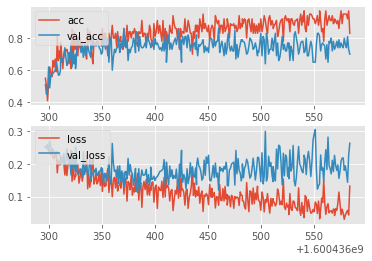

In [17]:
create_acc_loss_graph(model_name)
# Graph diverges after 8 epochs